# Spam Filtering Using Gaussian Naive Bayes
---
Use the `spambase.data` file and the Gaussian Naive Bayes algorithm to build a simple spam detection algorithm. You can get accuracies around 80% with this simple classifier that is quickly trained.

In [57]:
%matplotlib inline
import pandas as pd
import sklearn, sklearn.model_selection, sklearn.linear_model, sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Read the data

---

We need to read in the data from the spambase.data which is in CSV format. Pandas is perfect for this. If you look at the spambase.data file, you'll notice that there are no column headers and that the identification for spam vs. non-spam is found in column 57. So make sure you set the `header` argument to `None` and the `index_col` argument to `57`.

In [58]:
data = pd.read_csv('~/data/spam.data/spambase.data', header=None, index_col=57)

## Split the data

---

Now we want to split the data into training and testing sets. Scikit-learn has a great function for this: `sklearn.model_selection.train_test_split()`. The first parameter is the data to split, `data` in my case. We need to make sure to tell it to split the training and testing set in half by passing `0.5` to the `test_size` argument. Also, set the `random_state` argument to `np.random.RandomState()` so that the data is shuffled. (This is important since `spambase.data` is sorted by class).

In [59]:
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.5, random_state = np.random.RandomState())

## Get the prior probabilities

---

Note that the `spambase.data` file has approximately 40% of the emails categorized as spam, so our split should reflect that. Since the `train_test_split()` function returned our split training and testing sets as pandas dataframes and since we set the index column to be the class of the instance, when we say `X_train.loc[1]` we are selecting all of the rows in the training set that have class 1. That is, select all the spam instances. Similarly, we can select all the non-spam (or ham) instances by doing `X_train.loc[0]`. 

In [60]:
prob_spam_train = len(X_train.loc[1].index)/len(X_train.index)
prob_spam_train

0.391304347826087

In [61]:
prob_ham_train = len(X_train.loc[0].index) / len(X_train.index)
prob_ham_train

0.6086956521739131

## Get the means and the standard deviations over the columns

---

In order to calculate the probability (which we simulate with the probability density function), we need to have the mean and standard deviation of each column for a given class (spam or ham). This is made quite easy by using the pandas [`describe()` function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html). The result of `describe()` is a dataframe and to get the column means or standard deviations, we merely need to index the row labeled `mean` or `std` respectively.

In [62]:
train_spam_col_means = X_train.loc[1].describe().loc['mean']

In [63]:
train_spam_col_stds = X_train.loc[1].describe().loc['std']
train_spam_col_stds

0       0.295060
1       0.305692
2       0.498878
3       0.307402
4       0.724757
5       0.325110
6       0.586261
7       0.539826
8       0.320622
9       0.615502
10      0.246592
11      0.617959
12      0.383739
13      0.319690
14      0.420628
15      0.960598
16      0.582982
17      0.645534
18      1.572560
19      0.619001
20      1.148295
21      1.372260
22      0.513540
23      0.495577
24      0.159046
25      0.085221
26      0.012326
27      0.129907
28      0.016824
29      0.143235
30      0.045333
31      0.000000
32      0.126050
33      0.049176
34      0.080241
35      0.155177
36      0.265871
37      0.034806
38      0.077791
39      0.173666
40      0.003333
41      0.027024
42      0.055879
43      0.066815
44      0.328738
45      0.168451
46      0.013704
47      0.034324
48      0.079605
49      0.128001
50      0.036971
51      0.782260
52      0.317079
53      0.829306
54     43.190438
55    188.448258
56    701.534351
Name: std, dtype: float64

In [64]:
train_ham_col_means = X_train.loc[0].describe().loc['mean']

In [65]:
train_ham_col_stds = X_train.loc[0].describe().loc['std']
train_ham_col_stds

0       0.337523
1       1.646836
2       0.520383
3       0.028987
4       0.601782
5       0.251777
6       0.113414
7       0.171151
8       0.165015
9       0.455838
10      0.137135
11      0.978761
12      0.246527
13      0.263251
14      0.089912
15      0.645691
16      0.216997
17      0.434700
18      1.802212
19      0.091074
20      1.051929
21      0.604930
22      0.048148
23      0.275826
24      2.020171
25      1.109834
26      4.469851
27      0.641305
28      0.563995
29      0.534875
30      0.424582
31      0.380305
32      0.556534
33      0.380928
34      0.533286
35      0.494299
36      0.521607
37      0.384699
38      0.654107
39      0.389282
40      0.393934
41      0.742509
42      0.274242
43      1.009361
44      1.392908
45      1.273679
46      0.111902
47      0.409530
48      0.314919
49      0.240396
50      0.076622
51      0.920151
52      0.073119
53      0.279177
54      1.654137
55     26.943047
56    336.583267
Name: std, dtype: float64

## Define a function to calculate the sum of the log of the probabilities

---

This function returns the result of the following equation:

$$\log{P(\textit{class})} + \sum_i \log{P(x_i \text{ | } \textit{class})}$$

Where 

$$P(x_i \text{ | } c_j) = N(x_i ; \mu_{i,c_j} , \sigma_{i, c_j})$$

and

$$N(x; \mu , \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$ 

Again, Pandas makes this easy. It'll be the case that `x`, `mus`, and `sigmas` are all pandas dataframes with 1 row and 57 columns, so we can add, subtract, multiply, eponentiate, log, or divide on an item-by-item basis. So `x - mus` is also a 1 x 57 dataframe, for example. Additionally, the pandas `sum()` function ignores `NaN` values by default, so there isn't anything we need to do to avoid them (i.e. when the std is very large).

In [84]:
def sum_of_log_probs(P_class, x, mus, sigmas):
    return np.log(P_class) + np.log((1 / (np.sqrt(2 * np.pi) * sigmas)) * np.exp(-((x - mus)**2 / (2 * sigmas**2)))).sum()

## Given an instance $\mathbf{\overrightarrow{x}}$, predict its class

---

Determine a class of an instance. Calculate the following

$$class_{NB}\big(\overrightarrow{\mathbf{x}}\big) = \underset{\textit{class} \in \{0, 1\}}{\mathrm{argmax}} \Big(\log{P(\textit{class})} + \sum_i \log{P(x_i \text{ | } \textit{class})} \Big)$$

where $P(x_i \text{ | } c_j)$ is as given previously.

In [85]:
def predict(x):
    p_spam = sum_of_log_probs(prob_spam_train, x, train_spam_col_means, train_spam_col_stds)
    p_ham = sum_of_log_probs(prob_ham_train, x, train_ham_col_means, train_ham_col_stds)
    return 1 if p_spam > p_ham else 0

## Classify all instances in the test set

---

Walk over the test set predicting each of the instances. Here's another time when pandas makes this nice. The `pandas.DataFrame.iterrows()` function returns a tuple `(index, row dataframe)`. So we have the actual value, which is stored in the index column since that's what was set by the `index_col` argument of the `pandas.read_csv()` function.

*Note: `numpy.log()` will return a runtime warning if the value it gets is equal to 0.0. It is fine for us to ignore this.*

In [86]:
NB_y_pred = X_test.apply(predict, axis=1)

/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [87]:
NB_confusion_matrix = sklearn.metrics.confusion_matrix(y_true=X_test.index.values, y_pred=NB_y_pred)
NB_accuracy = sklearn.metrics.accuracy_score(y_true=X_test.index.values, y_pred=NB_y_pred)
NB_precision = sklearn.metrics.precision_score(y_true=X_test.index.values, y_pred=NB_y_pred)
NB_recall = sklearn.metrics.recall_score(y_true=X_test.index.values, y_pred=NB_y_pred)
print(' accuracy: {:.5f}\n'
      'precision: {:.5f}\n'
      '   recall: {:.5f}'.format(NB_accuracy, NB_precision, NB_recall))

 accuracy: 0.81269
precision: 0.69435
   recall: 0.94304


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.style.use('seaborn-dark')

## Plot the confusion matrix

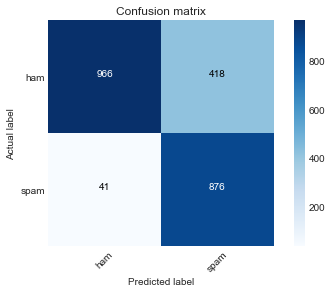

In [54]:
plt.figure()
plot_confusion_matrix(NB_confusion_matrix, classes=('ham', 'spam'), title='Confusion matrix')

## Part 2: Using a library to run a logistic regressor

---

This is simply a matter of running sklearn's LogisticRegression() and the various sklearn metrics functions.

In [50]:
logistic_regressor = sklearn.linear_model.LogisticRegression().fit(X_train, X_train.index.values)
LR_y_pred = logistic_regressor.predict(X_test)

In [51]:
LR_accuracy = sklearn.metrics.accuracy_score(y_true=X_test.index.values, y_pred=LR_y_pred)
LR_precision = sklearn.metrics.precision_score(y_true=X_test.index.values, y_pred=LR_y_pred)
LR_recall = sklearn.metrics.recall_score(y_true=X_test.index.values, y_pred=LR_y_pred)
print(' accuracy: {:.4f}\n'
      'precision: {:.4f}\n'
      '   recall: {:.4f}'.format(LR_accuracy, LR_precision, LR_recall))

 accuracy: 0.9187
precision: 0.9092
   recall: 0.8844


In [52]:
LR_confusion_matrix = sklearn.metrics.confusion_matrix(y_true=X_test.index.values, y_pred=LR_y_pred)

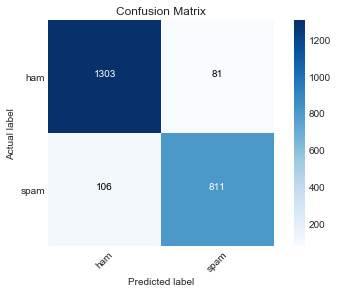

In [53]:
plot_confusion_matrix(LR_confusion_matrix, classes=('ham', 'spam'), title='Confusion Matrix')